# Spectral Type Classification, Filter Curves and Colours with Python

In [104]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits 
from astropy.visualization import ZScaleInterval, ImageNormalize

from astropy.modeling import models, fitting
import astropy.units as u

Observed spectra, like observed images, are stored in FITS files (https://de.wikipedia.org/wiki/Flexible_Image_Transport_System). The [astropy project provides the FITS module](http://docs.astropy.org/en/stable/io/fits/index.html) for reading and writing FITS files in Python. 

In this exercise we will use the following Python packages:
* Astropy to read in spectra from FITS files 
* Matplotlib to display them on screen. 
* Numpy to manipulate the spectra.

The goal of this exercise is to use the Harvard classification system to determine the spectral type of 13 stars based on the strengths of several well-known absorption lines. We will also use the transmission curves for the B and V filter to derive the "colour" of the stars (optional task).

<div class="alert alert-block alert-info">
    When answering the questions that are not code or plots, try to work with "markdown" (normal text as this one here). We provided you with the cells labelled "<b>Answer</b>". You can "run" these cells with markdown formatting to get non-code text output.
</div>

# Part 1 - Plotting spectra in Python

## 1. The FITS file

All fits files use the ``Header-Data-Unit``, or HDU to store data. This can either be as tables (1D data), images (2D data) or data cubes (3D data). A single FITS files can contain several different HDUs and they can be mixed. For example, a FITS file may contain 4 images and 2 tables, each in separate HDUs. Hence when we open a FITS file, we must also know which HDU to look at to find the data we want.

### Opening
* Choose a file to open
* Use ``fits.open()`` to get a handle to the file

  To access different HDUs, use the ``[n]`` notation after the HDU variable name, where ``n`` is the HDU number we want


* Display the header of primary (i.e. ``[0]``) HDU in the file with the ``.header`` attribute
  
Look at the [astropy FITS module documentation](http://docs.astropy.org/en/stable/io/fits/index.html) if you need help.

If we were to simply ``open()`` the files, we would need to care about closing them again after we are done importing the data. To make our lives easier, we can use Python's ``with`` syntax, which automatically takes care of that. Inside the ``with`` block, we import the data to our internal variables, which we can use from that point on, without having to touch the original file again (unless we need to import from a different file of course).

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Complete the following code to load the file data into the <tt>header</tt> and <tt>data</tt> variables. You might need to try different HDUs, as escribed above, to get the correct data. Remember you can always use <tt>print(...)</tt> to take a look at what is stored in your variables!</p>
</div>

In [32]:
filename = "00.fits"

with fits.open(filename) as file:
    data = file[1].data  
    header = file[1].header
    naxis = header["NAXIS1"]
    CTYPE1 = header["CTYPE1"]
    CRPIX1 = header["CRPIX1"]
    CRVAL1 = header["CRVAL1"]
    CDELT1 = header["CDELT1"]
 
file.info()
print(header)
print(data)
print("Naxis1: amount of data points: ", naxis)
print("type of transformation: ", CTYPE1)
print("reference pixel, with value: ", CRPIX1)
print("wavelenght value lamda 0 in meter: ", CRVAL1)
print("step size / bin width, delta lamda in meter: ", CDELT1)


Filename: 00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 ImageHDU        16   (4771,)   float32   
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    1 / number of array dimensions                     NAXIS1  =                 4771                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               WCSAXES =                    1 / Number of coordinate axes                      CRPIX1  =                  1.0 / Pixel coordinate of reference point            CDELT1  =                5E-10 / [m] Coordinate increment at reference point    CUNIT1  = 'm'                  / Units of coordinate increment and value        CTYPE1

### Axis information

First, we will take a look at the axis information. As you probably know, spectral data usually consists of wavelength on the x-axis and intensities (in various units) on the y-axis. In the data we are using here, there is no wavelength axis available, only information on how to construct it.

In the FITS header, we will usually find some info about the axis present in the file, somewhere close to the top. The first keyword you should be looking for is ``NAXIS``, which tells us the number of axis in the data (e.g. 1 for simple lists, 2 for images or multi-column tables, 3 for datacubes). According to this number, there will be ``n`` more keywords in the style of ``NAXIS1``, ``NAXIS2`` and so on, each telling us the length (=number of data points) on each axis.
We can accessing the values in these header fields via ``header["KEYWORD"]``.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Take a look at the values and write a short interpretation of the numbers you see!</p>
</div>

**Answer:**
Naxis is 1, so it is a list. The number of data points on this axis (naxis1) is 4771. 


Next, let's look at the values which actually tell us how to construct our wavelength axis. In our data, this information is stored in the "WCS"-block of the header, which stands for "World Coordinate System". This is more commonly used for defining the coordinate axis of a 2D image, but in our case, it holds the information necessary to convert the position of the data points to wavelengths. The following keywords are useful:
* ``WCSDIM``...number of dimensions/axes of the "coordinate system"
* ``CTYPE1``...type of transformation used on axis 1
* ``CRPIX1``...reference pixel of axis 1, which has the value of:
* ``CRVAL1``...reference value of axis 1, in our case equivalent to the wavelength value of the reference (here = first) pixel $\lambda_0$ in Ångström.
* ``CDELT1``...step size of axis 1, in our case the wavelength intervals, or bin width, $\Delta\lambda$ in Ångström.

<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>Again display those values from the header and try to answer the following questions with the information you now obtained:</p>
    <ol>
        <li>At what wavelength does the spectrum start?</li>
        <li>How many wavelength "bins" (number of data points) are there in the spectrum?</li>
        <li>What is the step between each bin?</li>
        <li>And using all those values, at what wavelength does the spectrum end?</li>
    </ol>
</div>

**Answer:** 
1. 1.15 * 10^-7 [m]
2. 4771 
3. 5e-10 [m]
4. 25.005 e-7 [m]

### Extract the data

The FITS file (or, to be precise, the HDU) contains the spectrum in the ``data`` property. Accessing this will return a Numpy Array, which can be used directly as your y-data. For the x-data, as stated above we need to construct it first. In the previous section, we obtained all necessary values to do this. What we want is an Array of equally spaced points, starting and ending at the wavelengths you determined above. For this, we can use ``np.arange()``, which is Numpy's Array-version of Python's standard ``range()`` function, which does just that! If you don't know the parameters that go into this function, you can type ``help(np.arange)`` to look it up.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>We provided you with the beginning, now replace the <tt>...</tt> placeholders below to construct your axes!</p>
</div>

In [28]:
x = np.arange(1.15*10**(-7), 25.005*10**(-7), 5*10**(-10))
y = data


You can now check if your two axes have the same length. If they don't, it is not possible to match $x$ and $y$ for each data point. 

In [29]:
print("x:", len(x))
print("y:", len(y))


x: 4771
y: 4771


## 2. Display the spectrum

### Basics of plotting

The most straightforward way to plot this kind of data is to simply use the matplotlib function ``plt.plot()``. Again, if you aren't familiar with the syntax, use ``help(plt.plot)``. Try it out and have a first look at the spectrum!

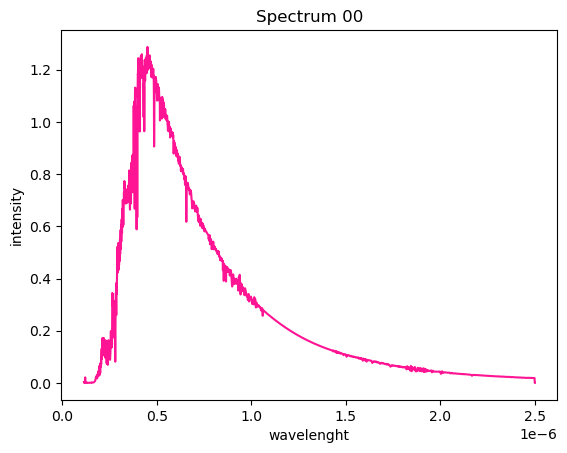

In [35]:
plt.plot(x, y, color = "#FF1493")
plt.title("Spectrum 00")
plt.xlabel("wavelenght")
plt.ylabel("intensity")
plt.show()



You can also display different regions of the spectrum by setting the limits of the x-axis using ``plt.xlim()``.

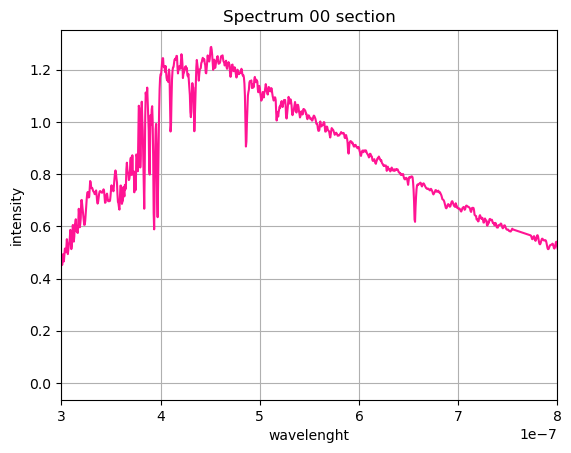

In [92]:
plt.plot(x, y, color = "#FF1493")
plt.title("Spectrum 00 section")
plt.xlabel("wavelenght")
plt.ylabel("intensity")
plt.xlim(0.3*10**(-6), 0.8*10**(-6))
plt.grid(True)
plt.show()



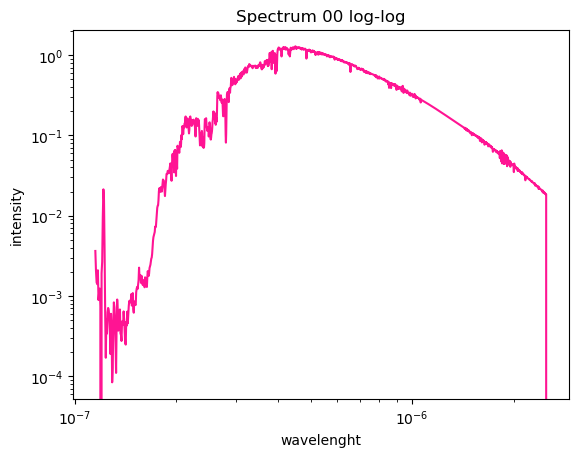

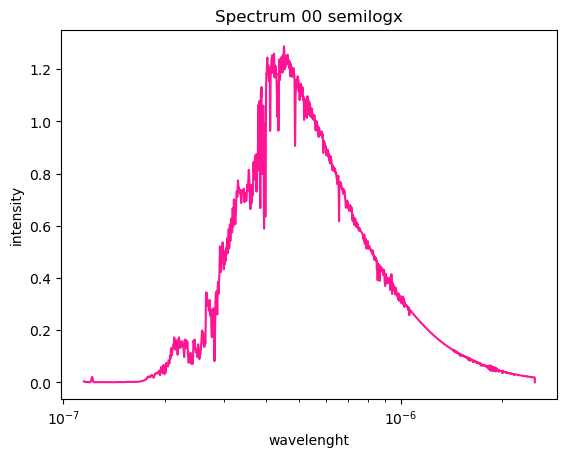

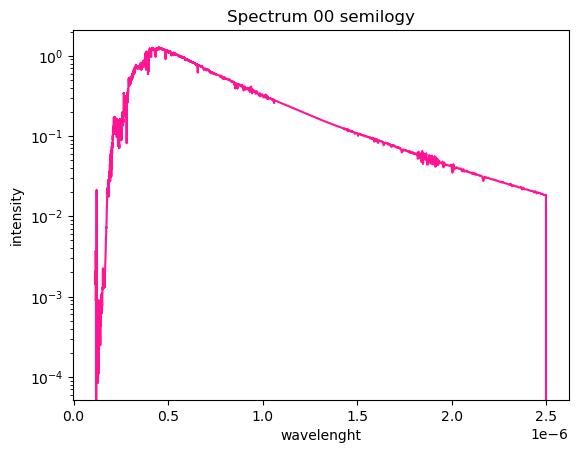

In [45]:
plt.plot(x, y, color = "#FF1493")
plt.title("Spectrum 00 log-log")
plt.xlabel("wavelenght")
plt.ylabel("intensity")
plt.loglog()
plt.show()

plt.plot(x, y, color = "#FF1493")
plt.title("Spectrum 00 semilogx")
plt.xlabel("wavelenght")
plt.ylabel("intensity")
plt.semilogx()
plt.show()

plt.plot(x, y, color = "#FF1493")
plt.title("Spectrum 00 semilogy")
plt.xlabel("wavelenght")
plt.ylabel("intensity")
plt.semilogy()
plt.show()

If you want logarithmic axes, use ``plt.semilogy()``, ``plt.semilogx()`` or ``plt.loglog()``.

<div class="alert alert-block alert-warning">
    <h4>Question</h4>
    <p>Discuss the pros and cons of logarithmic plots, both in general and in particular for the spectra we're using. What is the best option in this case and why? Decide for one (plot, semilog or loglog), give a reasoning for your choice and <strong>stick with it for all plots in this exercise for consistency!</strong></p>
</div>

**Answer:**\
Linear plot: The pro for the linear plot is that it is intuitivly. It is more difficult though, if for example the flux is in orders of magnitudes, because the plot cannot display small features and it is very difficult to show both bright peaks and faint continuums.\  
Semilog plot: Strong peaks and faint continuum can be visible. It also still preserves one of the properties, for example wavelength, which makes it easier to read. On the other hand, it cannot plot negative flux. The visual distances dont correspond to the absolute flux differences.\
Loglog plot: Useful when both axes span many orders of magnitude and you want to see power-law behavior as straight lines. Unfortunatly, it is less intuitive. It can obscure the peak and and make the spectrum harder to interpret. 


### Analysing the plot

You are now in a position to start analysing the plotted spectrum. To zoom in on different parts, use ``plt.xlim()`` as discussed before.

<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>Try to answer the following questions using your plot. You might need to look up wavelengths of prominent absorption lines or use the pdf files provided in Moodle:</p>
    <ol>
        <li>Is the spectrum normalised or not? How can you tell?</li>
        <li>At what wavelength is the peak (highest value) of the spectrum? Note that the data is likely noisy, so try to estimate the actual peak (by eye), don't just take the highest pixel if it doesn't fit.</li>
        <li>At what wavelengths are the strongest absorption features (spectral lines) in this spectrum? Make a list of the wavelengths for the 5 strongest features and note the relative depth of each feature and try to guess the element which might have produced each line! In the "Comments" column, you can add general remarks of the absorption feature.</li>
        <li>What could these elements tell us about the star? Hot/Cold? Young/old? Something else?</li>
        <li>What is happening around 3800 Å (if anything, not every spectrum has that feature (why?))?</li>
    </ol>
</div>

_The relative depth is a measurement of how far an absorption line dips down from the continuum. For example, a line with a minimum very close to the x-axis might have a relative depth close to .9 or 90 %, whereas a line that only goes half the way from the continuum to the bottom will have a relative depth of around .5 or 50 %._

1) nicht normiert (?)
2) at around 0.46 nm 

4) B star: cold, rather old, off main sequence because of Ca and Mg

**Answer:**
| Wavelength [Å]  | Absorption Feature   | Element    | Comments |
|-----------------|----------------------|------------|----------|
|    2750         |  ~66% relative depth |Magnesium (MgII)         |clear visible absolute line with large rel depth compared to continuum|
|    3930         |  ~44% relative depth |Calcium Ca      |4 different lines close 
|    4340         |~16.5% relative depth |Hydrogen gamma |clearly distinguishable absolute line relative to continuum 
|    4470         |~16.5% relative depth |Helium (He I) | 2 neighboring absolute lines 
|    4860         | ~25%  relative depth | Hydrogen beta | clear absolute line relative to continuum 

## 3. Classify the star using the Harvard (-Yerkes) scheme

The next step is to classify the provided spectra using the well-known Harvard (-Yerkes) scheme, i.e. the OBAFGKM spectral classes.

The important lines in this classification scheme are: the Balmer Lines (esp. H beta, delta and epsilon), Calcium H+K doublet, Calcium G line, the Sodium doublet and the Helium lines. Slightly different variants of this scheme exist, we provided you with a rather simple one using less different lines, which you can find as a pdf file on Moodle ("Spektralklassifizierung Flowchart").

In this flowchart, you start at the top left and in each step decide if the spectrum exhibits the characteristics in question. A line counts as "being present" if it is clearly distinguishable from the background noise of the continuum. The meaning of the central lower decision ("Ca H & K <=> H epsilon & delta") is whether the Ca H & K lines (which will usually be about equally strong/deep) are less (<), roughly equal (=) ore more (>) strong/deep than the average of the Balmer lines H epsilon and H delta.

The "official" distinction between spectral types K and M, the TiO bands, can be tricky to spot in our example. The "best" ones to use are located around 5165, 6158 and 7054 Å. You can either try to use those, or come up with another way of telling those classes apart, by looking at the shape of the whole spectrum rather than individual lines.

All the borders between spectral classes are of course blurred, so you can use the subclasses denoted with arabic numericals 0-9 to achieve a better classification, or when you think a star seems to be "in between" two classes. Try to give an explanation of how "fine grained" of a subclass is even meaningful to use in the context of this exercise!

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Plot all of the spectra and classify them by the Harvard (-Yerkes) OBAFGKM scheme. Be sure to include a reasoning for your decisions (i.e. <i>why</i> did you classify star X as class Y). Try to include markers in your plots denoting the lines used in the classification.</p>
</div>

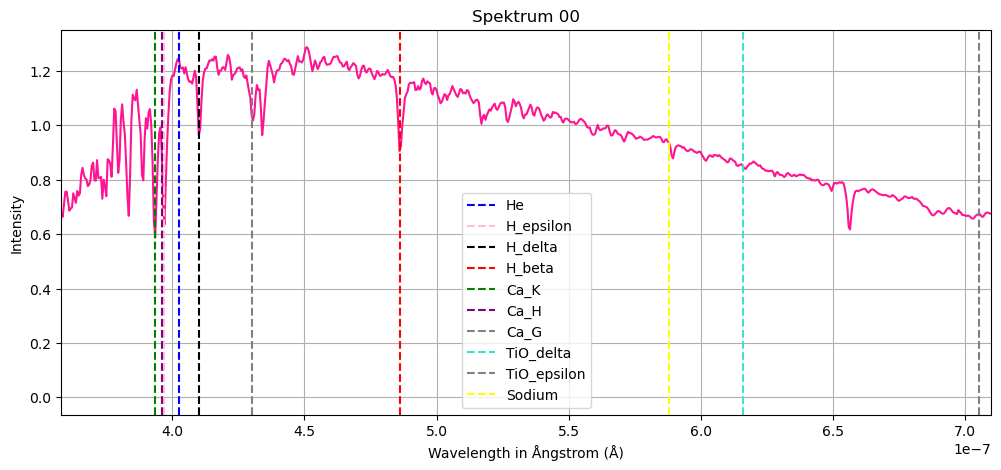

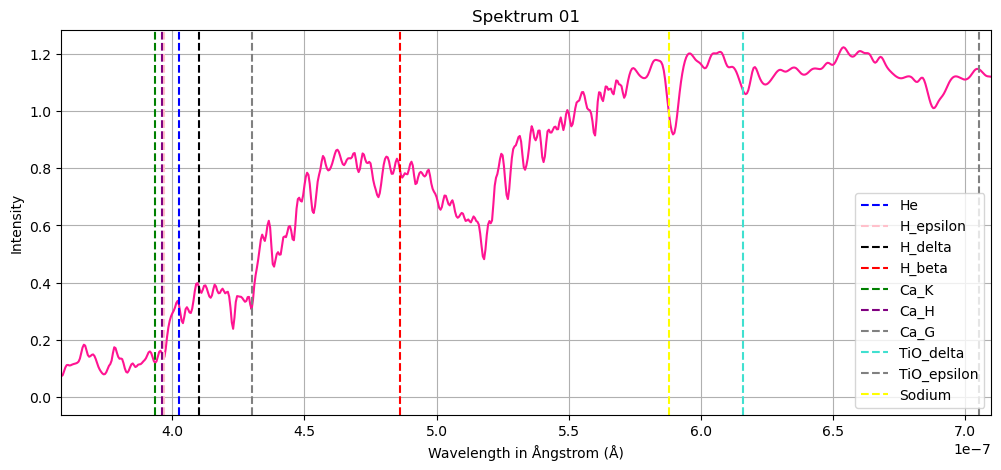

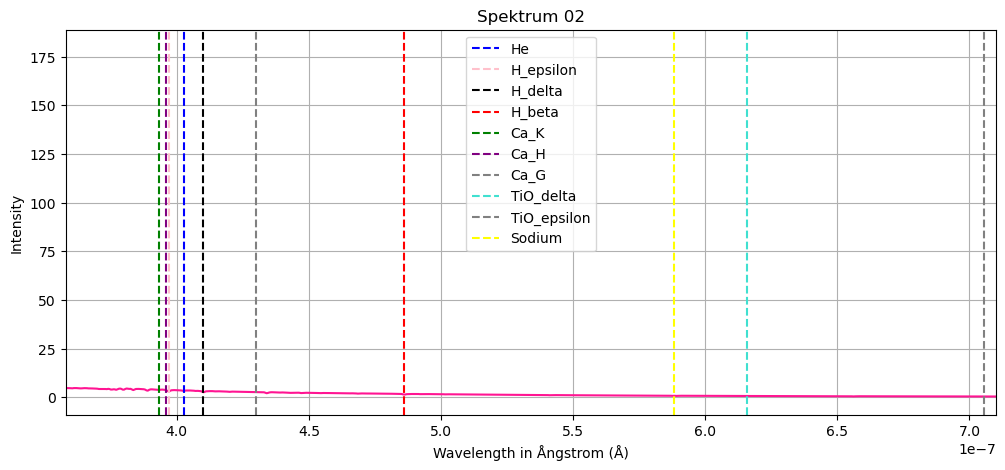

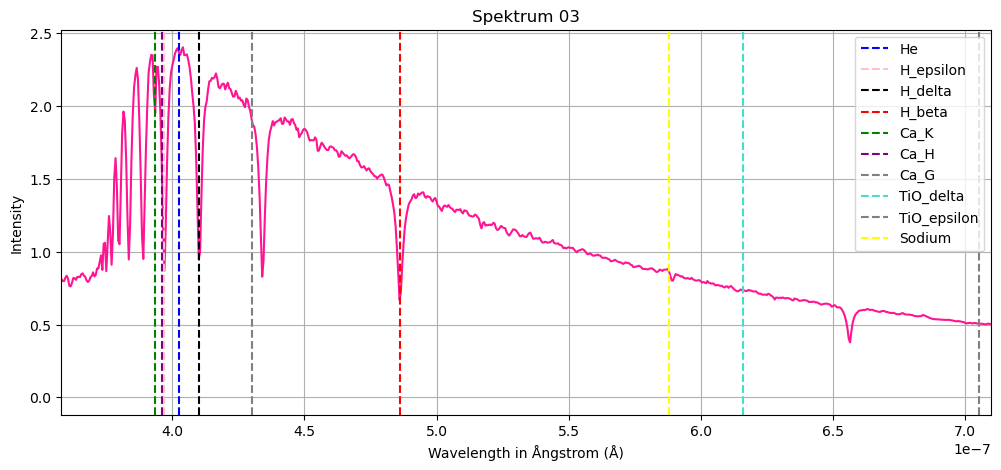

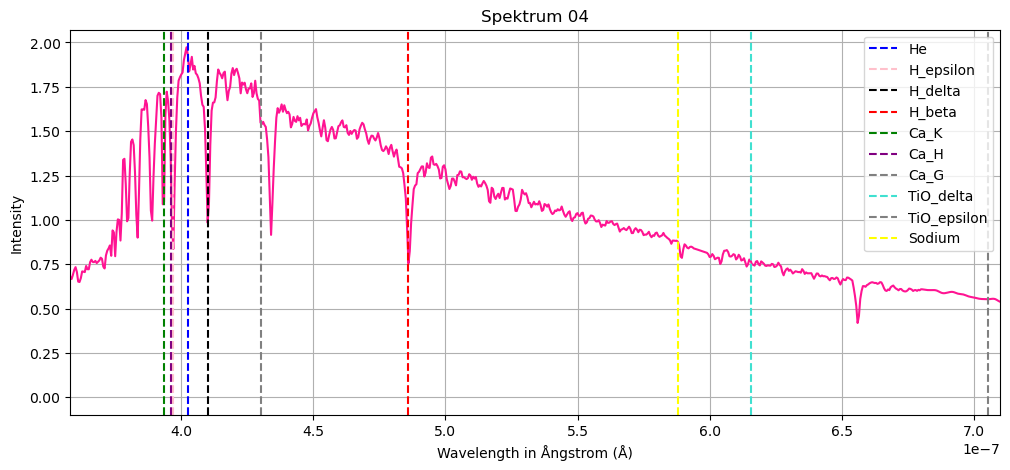

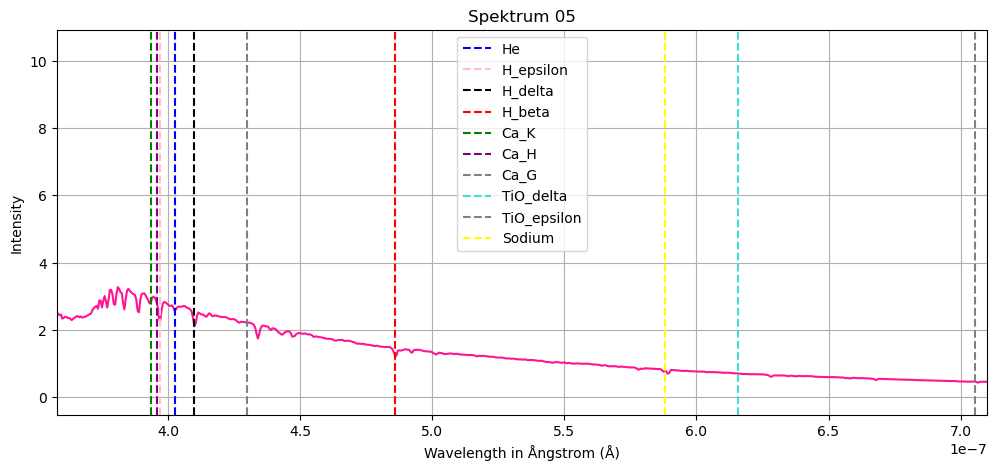

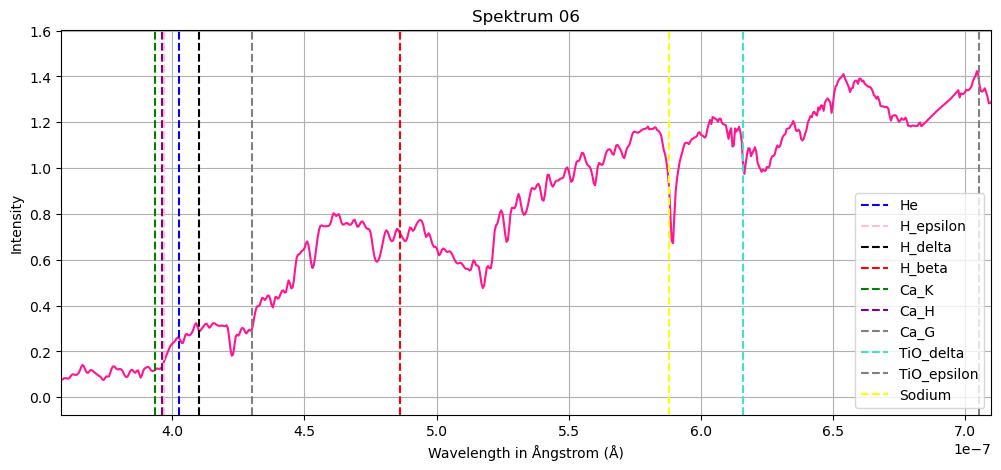

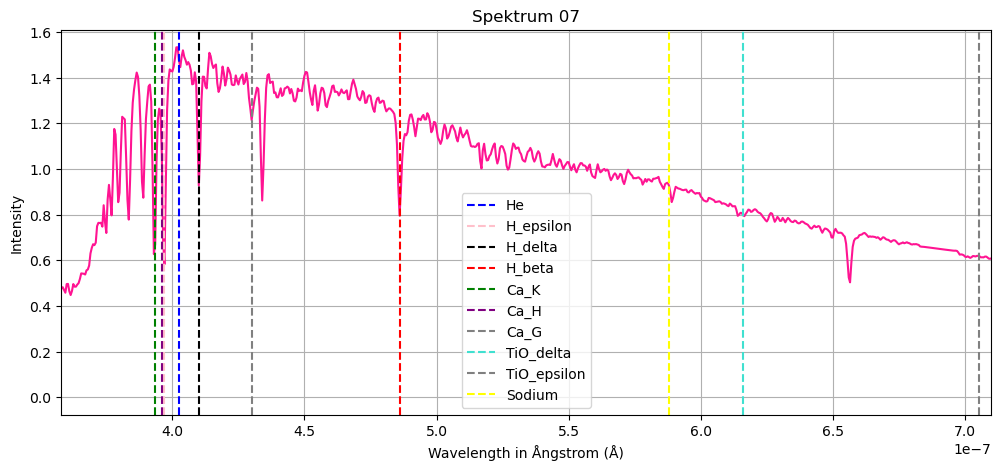

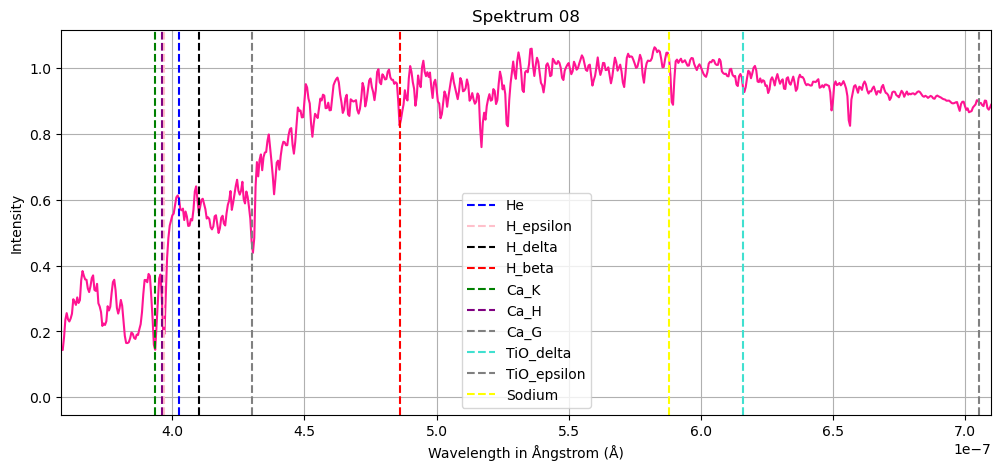

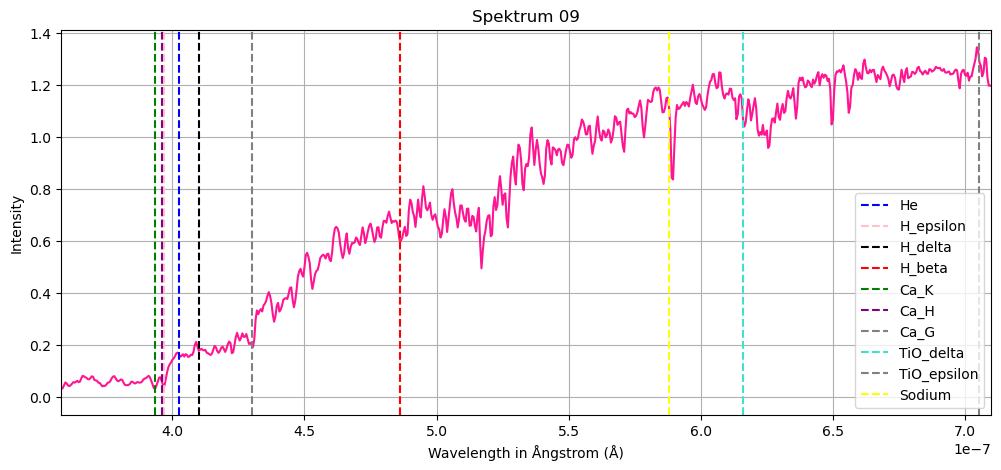

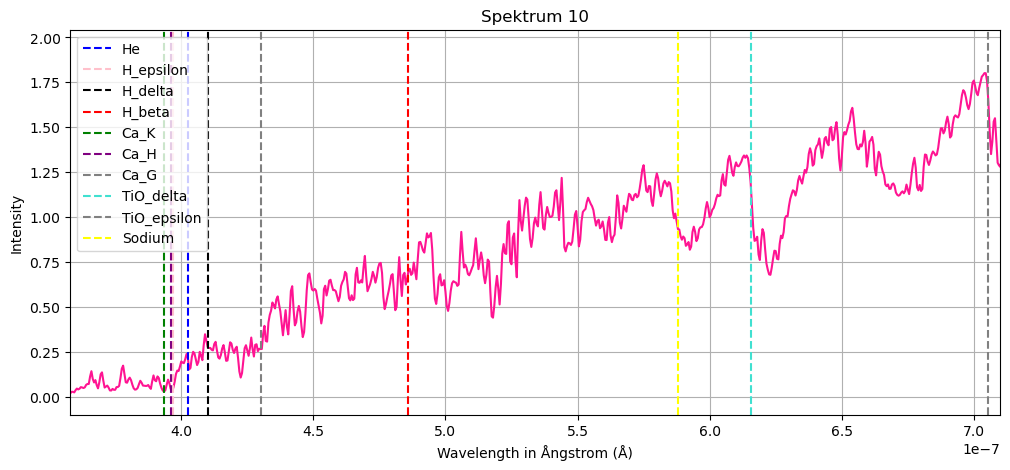

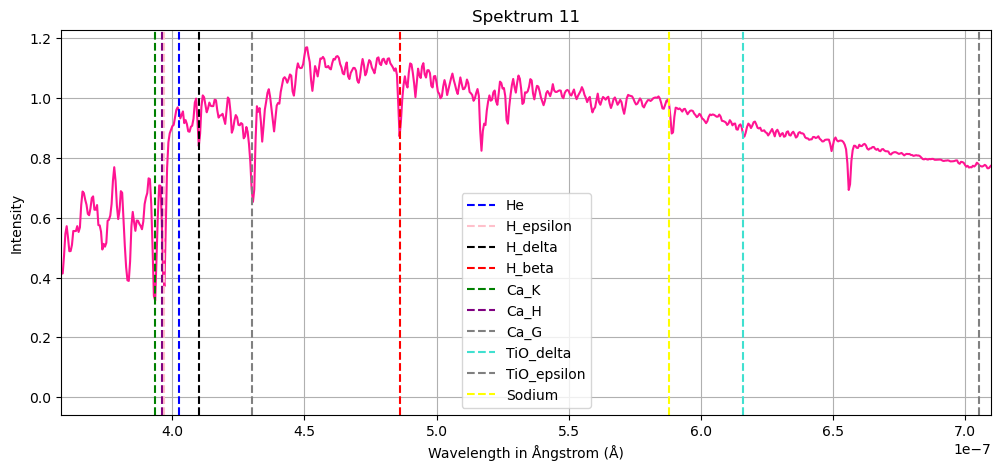

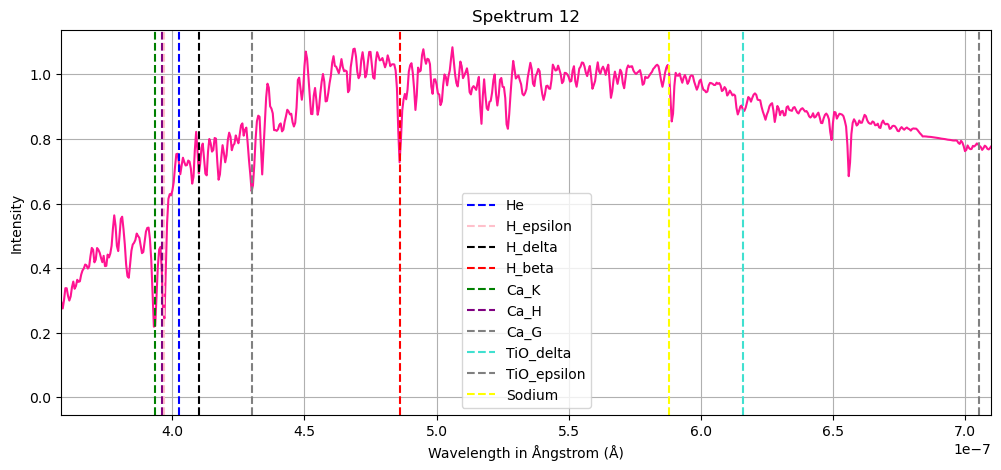

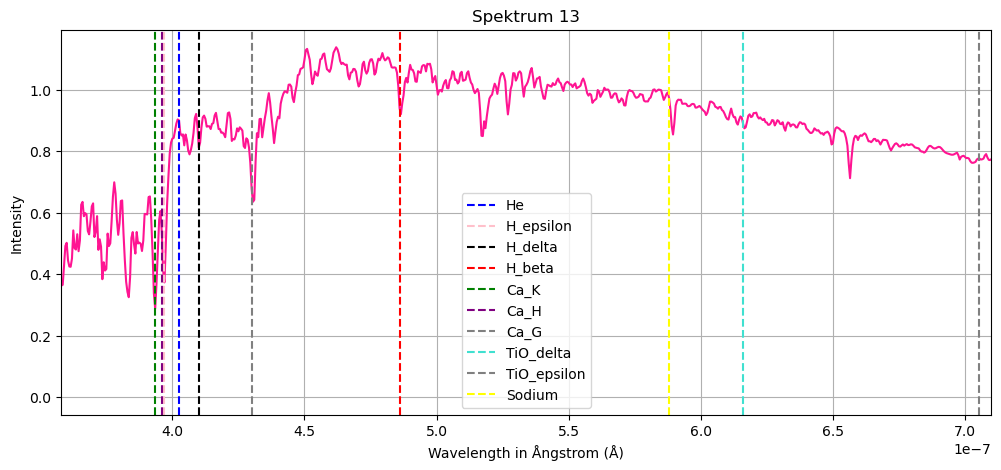

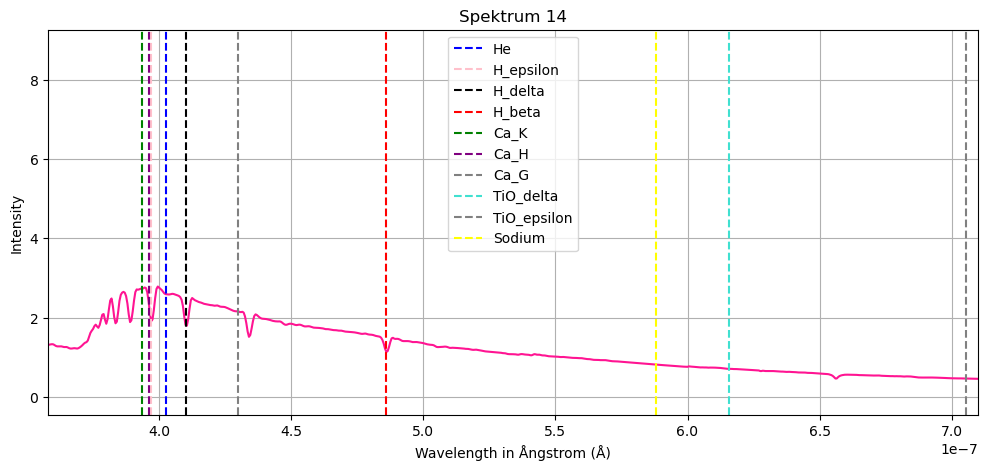

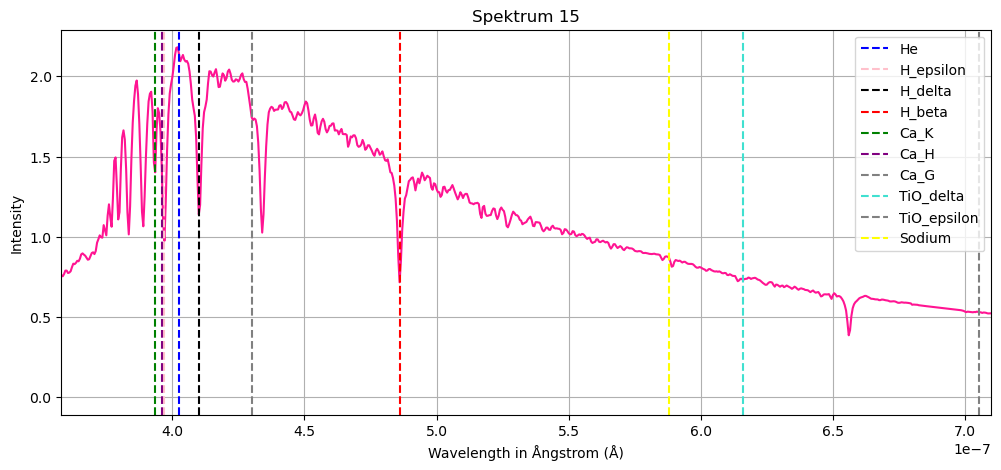

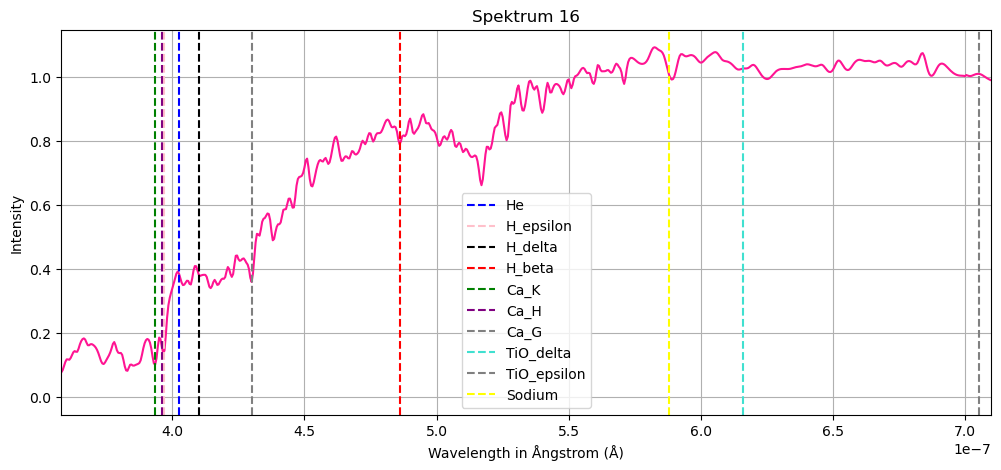

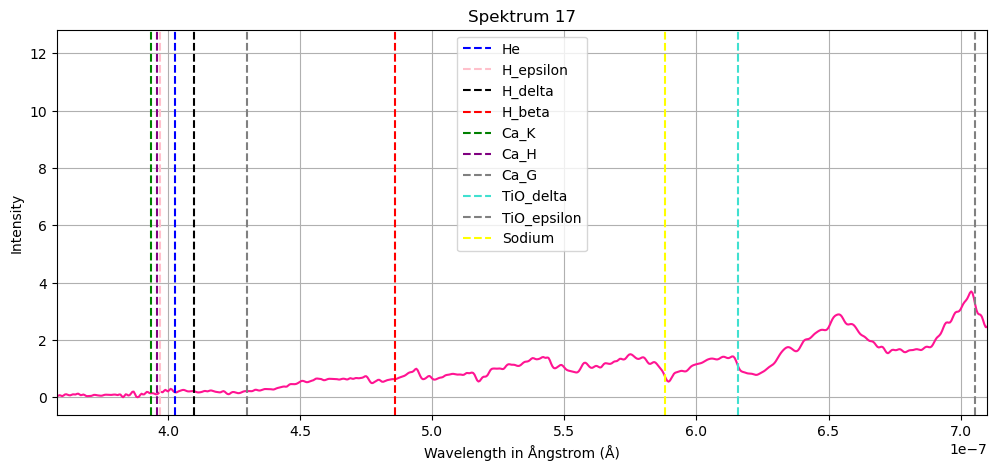

In [109]:
indx = range(18)

for i in indx:

    with fits.open(f"C:\\Users\\InesH\\OneDrive\\Uni\\7.Semester\\observatoriumspraktikum/{i:02d}.fits") as file:
        data_i = file[1].data

        n_datapoints_i = header["NAXIS1"]
        first_lambda_i = header["CRVAL1"]
        delta_step_i = header["CDELT1"]
        last_lambda_i = first_lambda_i + n_datapoints_i*delta_step_i

        x_i = np.arange(first_lambda_i, last_lambda_i, delta_step_i)
        y_i = data_i
        
        bb = models.BlackBody(temperature=6000 * u.K, scale = 1 * u.erg / (u.cm**2 * u.s * u.AA * u.sr))
        flux_bb = bb(x)/np.max(bb(x))
        

        plt.figure(figsize= (12, 5))
        plt.plot(x_i, y_i, color =  "#ff1492")
        plt.title(f"Spektrum {i:02d}")
        plt.xlabel("Wavelength in Ångstrom (Å)")
        plt.ylabel("Intensity")
        plt.xlim(0.2*10**(-6), 0.7 *10**(-6))
        plt.grid()
        plt.axvline(0.4026E-6, linestyle='--', label = "He", color = "blue", alpha = 1)
        plt.axvline(0.3970E-6, linestyle='--', label = "H_epsilon", color = "pink", alpha = 1)
        plt.axvline(0.410E-6, linestyle='--', label = "H_delta", color = "black", alpha = 1)
        plt.axvline(0.486E-6, linestyle='--', label = "H_beta", color = "red", alpha = 1)
        plt.axvline(0.3934E-6, linestyle='--', label = "Ca_K", color = "green", alpha = 1)
        plt.axvline(0.396E-6, linestyle='--', label = "Ca_H", color = "purple", alpha = 1)
        plt.axvline(0.430E-6, linestyle='--', label = "Ca_G", color = "grey", alpha = 1)
        plt.axvline(0.6158E-6, linestyle='--', label = "TiO_delta", color = "turquoise", alpha = 1)
        plt.axvline(0.7054E-6, linestyle='--', label = "TiO_epsilon", color = "grey", alpha = 1)
        plt.axvline(0.588E-6, linestyle='--', label = "Sodium", color = "yellow", alpha = 1)
        plt.xlim(0.358*10**(-6), 0.71 *10**(-6))
        plt.legend()
        plt.show()

In order to classify the star from its spectrum, we use the flowchart provided on moodle. To start the classification, one has to look for the H_beta emission line and check, if it is visible in the spectrum. If the spectrum has an emission there, the HeI line needs to be checked. If it has an emission in HeI it can be classified as a B-star. Else the Ca_K and Ca_H needs to be compared to the H_epsilon and H_delta. If Ca_H and Ca_K are smaller than H_epsilon and H_delta, the spectrum belongs to an A-star. If its bigger, it is a G-star and if its rougly equal the spectrum belongs to a F-star. If there is no emission at H_beta, the blue continuum needs to be evaluated. If the spectrum is growing towards the blue continuum (getting bigger at smaller wavelengths) is can be classified as an O-star. Lastly, the TiO-emission needs to be compared. If it exist, the spectrum belongs to a M-star and else to a K-star. 

| spectrum | H_beta   | He I     | Ca H & K vs H_epsilon & H_delta | towards blue continuum | TiO | Star |
|----------|----------|----------|---------------------------------|------------------------|-----|------|
| 00 | yes | no | roughly equal | ||F |
| 01 | no| | | no | no | K |
| 02 | no | | | yes|  |  O |
|  03        |  yes        |   no        |      <                           |                        |     |    A  | 
|  04        |    yes      |   no       |    <                             |                        |     |     A | 
|  05        |   yes       |    yes      |                                 |                        |     |   B   | 
| 06         |     no     |          |                                 |      no                  | yes    |   M   | 
| 07         |  yes        | no         |           roughly equal                |                        |     |    F  | 
|  08        |  yes        |  no        |            >                     |                        |     |    G  | 
|  09        |     no     |          |                                 |                     no   |    no |     K | 
|   10       |    no      |          |                                 |                       no |   yes  |   M   | 
|  11        |   yes       |   no       |                >                 |                        |     |   G   | 
| 12         |   yes       |   no       |                >                 |                        |     |  G    | 
| 13         |   yes       |   no       |                >                 |                        |     |   G   | 
| 14         |   yes       |   yes       |                                 |                        |     |   B   | 
| 15         |   yes       |   no       |                <                 |                        |     |   A   | 
| 16         |   no       |          |                                 |             no           |  no   |   K   | 
| 17         |   no       |          |                                 |             no           |  yes   |  M    | 


If the H_beta emission line is existend, it is clearly visible in the spectrum, which makes the classification feasible. For HeI it is important to note to look for an emission peak, meaning the peak in the spectrum goes downwards. Because there are multiple emission lines in this area, it makes it more difficult to classify the spectrum. For this exercise the emission line at 4026Å was used. To compare between Ca_H and Ca_K versus H_epsilon and H_delta, the black body fit for each spectrum works for a comparison. The intensity of the peaks are compared from the black body fit. The blue continuum is visible, if the spectrum is more intense at shorter wavelenghts and decreases towards higher wavelengths. 

<div class="alert alert-block alert-warning">
    <h4>Further theoretical Questions</h4>
    <p>Why do strong Balmer lines mean we are looking at hotter stars? What could be happening in the stars' atmosphere to cause the Calcium H+K and Calcium G lines to be strongest in solar type (F, G) stars?</p>
</div>

**Answer:**



## 4. Luminosity class

If all stars were main sequence stars, the Harvard system would be enough to get a rough idea of what type of star we are looking at. However, stars change as they age. They evolve from main sequence stars to giant stars and thus their luminosity increases. Therefore, an extension to the classification system is used, the luminosity class, denoted with roman numericals. One way to determine whether a star is a main sequence (luminosity class V) or a giant (class I to III) is to look at its spectrum. We provided you with two additional spectra, which only differ in luminosity class (V and I), but have the same spectral class (A0).

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Open the following two files and plot their spectra in a single plot:</p>
    <ul>
        <li><tt>a0v.fits</tt></li>
        <li><tt>a0i.fits</tt></li>
    </ul>
</div>

<div class="alert alert-block alert-warning">
    <h4>Questions</h4>
    <p>What differences do you note between the spectra? What is the difference between the two stars, based on their classification (A0V and A0I)? Which of the following parameters are different, which are (roughly) the same and why: temperature, age, radius, mass, luminosity?</p>
</div>

**Answer:**



<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>Using the information from those two spectra (i.e. their differences), try to classify the previous spectra in terms of their luminosity classes. Now because we only have the example spectra for A-type stars here, it is sufficient to do this only for those stars which you previously classified as B, A or F. Any other spectral type is too different altogehter to allow any meaningful determination of luminosity class based on an A0I/A0V example.</p>
</div>

## 5. Spectrophotometry

To get a rough estimation of a star's colour, we can look at the flux of the spectrum in certain wavelength bands, which correspond to photometric filters. Since these filters are not perfect rectangles, but have a transmission curve, we provided you with approximate values for transmission at certain wavelength intervals for three of the most important filters, B, V and R.

<div class="alert alert-block alert-success">
    <h4>Task</h4>
    <p>You can use these filter curves to obtain the total (integrated) flux in the three filters for each star. By comparing the B, V and R values, you can calculate a "colour" for the star. Because the wavelength axis of the filter files is not the same as that of the spectra, you'll need to perform an interpolation of the filter curves using e.g. an appropriate numpy function.</p>
</div>

In [ ]:
# 3 filterkurven plotten; zumindest 0 spektrum; 1 filter mehr fluss als anderen; 
